# Prototyping

This notebook is my early thoughts and experiments on this project. It's pretty messy and I make no guarantees for comprehensibility.

Here's where I am: I just finished the first half of the fast.ai course, and I want to build something useful. So far I've been following along with the videos and notebooks as convenient, but I haven't done much on my own. So I'm trying to build an interesting ML project of my own with one rule: I can't use the fast.ai library, but I can see what they do and try to replicate it. PyTorch only.

Goal: make a license plate that I wouldn't have recognized recognizable.

### Possible datasets

1. https://www.kaggle.com/andrewmvd/car-plate-detection
    - Public domain (asks for credit)
    - 433
    - Quality maybe 7/10 (some images have plates small or missing)
1. https://www.kaggle.com/thamizhsterio/indian-license-plates
    - No license found--might be ok for personal use
    - 10000 (!)
    - Quality 9 (actually cropped, which is nice)
1. https://www.kaggle.com/mrugankray/license-plates?
    - No license found--hmm
    - 200 something
    - Quality 6
1. https://www.kaggle.com/pcmill/license-plates-on-vehicles?select=HCZyJ9TY6QizRhqI.jpeg
    - Public domain, no attribution listed
    - 399
    - Quality 7
1. http://www.zemris.fer.hr/projects/LicensePlates/english/results.shtml
    - License unclear
    - 500 images
    - Quality 10 (really good pictures; all look to have been taken by the student)

**I think I'll use 1, 4, and 5.**

In [4562]:
%matplotlib inline
import os
from time import time
from PIL import Image, ImageEnhance
from numpy import random
from matplotlib.pyplot import imshow
import cairo
import numpy as np
from IPython.display import Image as IImage

# I'm making an exception to my rule for this useful utility.
from fastai.vision import parallel

## Image degrading

In [13]:
!ls

prototyping.ipynb


In [1]:
import torchvision

In [15]:
base_path = '../data'

In [17]:
train_set = torchvision.datasets.ImageFolder(root=os.path.join(base_path, 'train'))

Directory structure:

- train
    - original
    - degraded
- valid
    - original
    - degraded

In [144]:
train_set.imgs[:10]

[('../data/train/original/06R3iOa3bATCEVXz.jpg', 0),
 ('../data/train/original/09Y0lBpIJ7tIplW2.jpg', 0),
 ('../data/train/original/0CDTBhPMJc1ZUf5S.jpg', 0),
 ('../data/train/original/0ETtCXFcSCgOLNyH.jpg', 0),
 ('../data/train/original/0KNVFEUQVov26wku.jpg', 0),
 ('../data/train/original/0WLUDeUFaBbyfqJK.jpg', 0),
 ('../data/train/original/0X1c3Yo2gzP46bNb.jpg', 0),
 ('../data/train/original/0X5bZskpz2fUUYVJ.jpg', 0),
 ('../data/train/original/0txdwQJANA69veu6.jpg', 0),
 ('../data/train/original/0u8gq295rn7kSbrq.jpg', 0)]

In [1092]:
img_size = 96
def degrade_image(input, i=None):  
    img = Image.open(input)
    w, h = img.size
    ratio = min(img_size / w, img_size / h)
    target_size = int(w*ratio),int(h*ratio)
    img = img.resize(target_size, resample=Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    img.save('./test-degrade.jpg', quality=q)

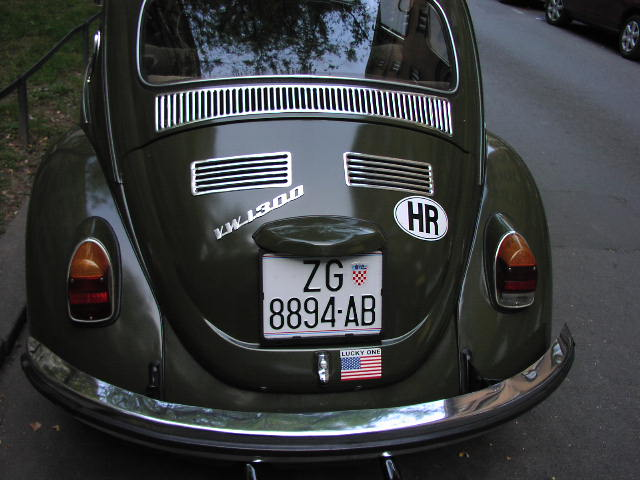

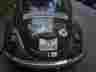

In [1584]:
# Test things out
max_width=500
rand_idx = random.randint(0, len(train_set.imgs))
degrade_image(train_set.imgs[rand_idx][0])
display(IImage(train_set.imgs[rand_idx][0], width=max_width, height=max_width))
display(IImage('test-degrade.jpg', width=max_width, height=max_width))

**Problem: the original problem was for upscaling cropped licenses.**

Synthetic data might be a good option here. What's worth weighing is whether the extra effort of creating 2D license plate images (or 3D) is a good investment for whatever we gain. If we decide to go that route, there could be several options:

- Processing
    - Has 2D, 3D options (incl. with lighting--possibly for glare)
    - Can save entire canvas: https://processing.org/reference/save_.html
    - How we might do this:
        - Create a 2D texture for the license plate
            - Get a bunch of license plate blank backgrounds--at least one for every state and maybe some from out of the country
            - Find a few different fonts that might fit on license plates
            - Composite the two together, making sure that text generation is parameterized such that it never overflows 
        - Project that texture onto a plane and rotate it randomly but within a range where the numbers are always visible to the user
        - Draw a random imagenet image as the background to get the license plate in context
            - Or maybe a picture of a car? That might make more sense. Are there any massive public domain car datasets?
        - Light the scene such that
            - The brightness of the light is the mean (or median?) value of the background and maybe the hue matches as well, but the license plate can always be seen
                - Note that we want to have a variety of different lighting conditions to train on
            - There is a probability, when the scene is light enough, that the letters on the license plate will be partially obsured. This could be a combination of two things:
                - The specularity of the plate
                - The brightness and direction of the light
        - Translate the entire scene parallel to the viewer
            - Note that we don't need to always keep the entire license plate in frame, so some slop here would be acceptable
- Cario library for drawing plates

What I'm attempting to make here is something that can generate a halfway-convincing license plate in 2d.

In [4561]:
# TODO (maybe): Might be nice to have a neural network that comes up with these too

def alphabet_serial_gen():
    return chr(ord("A") + random.randint(26))

def number_serial_gen():
    return str(random.randint(10))

def alphanumeric_serial_gen():
    return random.choice([alphabet_serial_gen, number_serial_gen])()

separators = ['-', '·']

def generate_plate_serial():
    num_chunks = random.randint(3) + 1
    serial_string = ""
    seperator = random.choice(separators)
    
    for i in range(num_chunks):
        chunk_generator = random.choice([alphabet_serial_gen, number_serial_gen, alphanumeric_serial_gen])
        chunk_len = random.randint(2) + (5 - num_chunks)
        serial_string += "".join([chunk_generator() for _ in range(chunk_len)])
        if i < num_chunks - 1:
            serial_string += random.choice([' ', seperator], p=[0.4, 0.6])
    
    return serial_string

    
generate_plate_serial()

'RZSY·P92'

In [3938]:
side_length = 2000
radius = 20/side_length
padding = 0.02
font_choices = [
    "Heavy Equipment",
    "Ubuntu Mono",
    "Ubuntu",
    "Lato",
    "JetBrains Mono",
    "Times New Roman",
    "FE-Font"
]
font_color_choices = [
    (1, 1, 1),
    (0, 0, 0),
    (1, 1, 0),
]
graphic_types = [
    "circle",
    "rectangle"
]

def generate_plate_params():
    return {
        "text": generate_plate_serial(),
        "padding": [(random.rand() * 0.06) + 0.01 for _ in range(2)],
        "font": random.choice(font_choices),
        "bold": random.rand() >= 0.3,
        "radius": random.rand() * 0.03
    }

def generate_plate(params, highlighted, dest):
    global side_length
    with cairo.ImageSurface(cairo.Format.ARGB32, side_length, side_length) as surface:
        context = cairo.Context(surface)

        context.scale(side_length, side_length)
        context.set_line_width(0.01)

        #context.rectangle(x, y, width, height)
        #context.stroke()
        context.select_font_face(params["font"], cairo.FONT_SLANT_NORMAL, 
        cairo.FONT_WEIGHT_BOLD if params["bold"] else cairo.FONT_WEIGHT_NORMAL)

        context.set_font_size(0.1)

        (tx, ty, tw, th, tdx, tdy) = context.text_extents(params["text"])

        w_padding, h_padding = params["padding"]
        width, height = tw + w_padding * 2, th + h_padding * 2

        x, y, x1, y1 = 0.5 - width/2, 0.5 - height/2, 0.5 + width/2, 0.5 + height/2

        is_white = False

        if highlighted:
            context.set_source_rgba(1, 1, 1, 1)
        else:
            if random.rand() < 0.8:
                if random.rand() < 0.5:
                    # Linear gradient
                    gradient = cairo.LinearGradient(random.rand(), random.rand(), random.rand(), random.rand())
                    gradient.add_color_stop_rgba(0, random.rand(), random.rand(), random.rand(), 1)
                    gradient.add_color_stop_rgba(1, random.rand(), random.rand(), random.rand(), 1)
                    context.set_source(gradient)
                else:
                    # Solid color
                    context.set_source_rgba(random.rand(), random.rand(), random.rand(), 1)
            else:
                # White
                is_white = True
                context.set_source_rgba(0.95, 0.95, 0.95, 1)
                


        def draw_rounded_rectangle(radius): 
            context.new_sub_path()
            context.arc(x + radius, y + radius, radius, np.pi * 1, np.pi * 1.5)
            context.arc(x1 - radius, y + radius, radius, np.pi * 1.5, np.pi * 0)
            context.arc(x1 - radius, y1 - radius, radius, np.pi * 0, np.pi * 0.5)
            context.arc(x + radius, y1 - radius, radius, np.pi * 0.5, np.pi * 1)
            context.close_path()


        draw_rounded_rectangle(params["radius"])
        context.fill()
        
        if not highlighted:
            # Abstract graphics pass
            with cairo.ImageSurface(cairo.Format.ARGB32, side_length, side_length) as graphics_surface:
                graphics_context = cairo.Context(graphics_surface)
                graphics_context.scale(side_length, side_length)
                element_count = random.randint(10)
                for i in range(element_count):
                    graphic_type = random.choice(graphic_types)
                    gx = x + (random.rand() * width)
                    gy = y + (random.rand() * height)
                    graphics_context.set_source_rgba(*[random.rand() for _ in range(4)])
                    
                    if graphic_type == "rectangle":
                        gw, gh = [(random.rand() * 0.5) + 0.01 for _ in range(2)]
                        
                        graphics_context.save()
                        graphics_context.translate(gx, gy)
                        graphics_context.rotate(np.pi * 2 * random.rand())
                        graphics_context.rectangle(-gw/2, -gh/2, gw, gh)
                        graphics_context.restore()
                    elif graphic_type == "circle":
                        c_radius = (random.rand() * 0.5) + 0.01
                        graphics_context.arc(gx, gy, c_radius, 0, np.pi * 2)
                    
                    graphics_context.set_line_width((random.rand() * 0.03) + 0.01)
                    random.choice([graphics_context.fill, graphics_context.stroke])()
                
                context.save()
                context.scale(1/side_length, 1/side_length)
                context.set_source_surface(graphics_surface)
                context.scale(side_length, side_length)
                draw_rounded_rectangle(params["radius"])

                context.clip()
                context.paint()
                context.restore()
                # context.restore()
        
        if highlighted or random.rand() < 0.5:
            context.set_line_width(0.01 if highlighted else random.rand() * 0.02)
            context.set_source_rgba(*((0,0,0) if highlighted else (random.rand(), random.rand(), random.rand())))
            draw_rounded_rectangle(params["radius"])
            context.stroke()

        context.move_to(0.5 - tw / 2, 0.5 + th / 2)
        font_color = (0,0,0) if is_white or highlighted else (
            font_color_choices[random.randint(len(font_color_choices))] if random.rand() < 0.5 else random.rand(3)
        )
        context.set_source_rgba(*font_color, 1)
        context.show_text(params["text"])
        
#         context.save()
#         context.set_source_rgba(0, 0, 1, 0.2)
#         context.rectangle(0, 0, 1, 1)
#         context.fill()
#         context.restore()
        
#         context.save()
#         context.scale(1/side_length, 1/side_length)
#         context.set_source_surface(cairo.ImageSurface.create_from_png('highlighted-plate.png'))
#         context.rectangle(0, 0, side_length, side_length)
#         context.clip()
#         context.paint()
#         context.restore()
        
        with cairo.ImageSurface(cairo.Format.ARGB32, int((width + padding * 2) * side_length), int((height + padding * 2) * side_length)) as cropped_surface:
            cc = cairo.Context(cropped_surface)
            number = 1000
            cc.scale(side_length, side_length)
            cc.save()
            cc.scale(1/side_length, 1/side_length)
            cc.translate((padding - x) * side_length, (padding - y) * side_length)
            cc.set_source_surface(surface)
            cc.scale(side_length, side_length)
            
#             cc.scale(number, number)
            cc.rectangle(0, 0, 1, 1)
#             cc.rectangle(0, 0, 1, 1)
            cc.clip()
            cc.paint()
#             cc.set_source_rgba(1, 0, 0, 0.2)
#             cc.rectangle(side_length * x, side_length * y, width * side_length, height * side_length)
#             cc.fill()
            cc.restore()
            cropped_surface.write_to_png(dest)

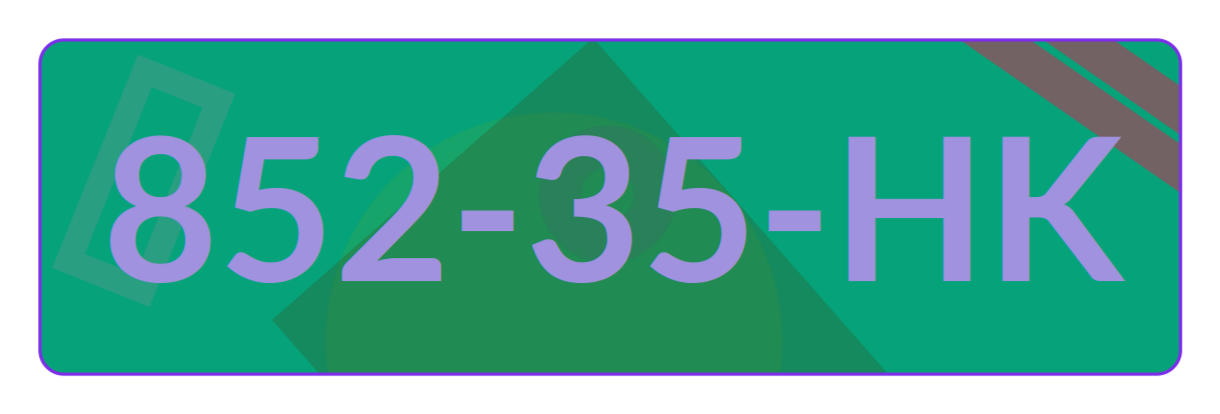

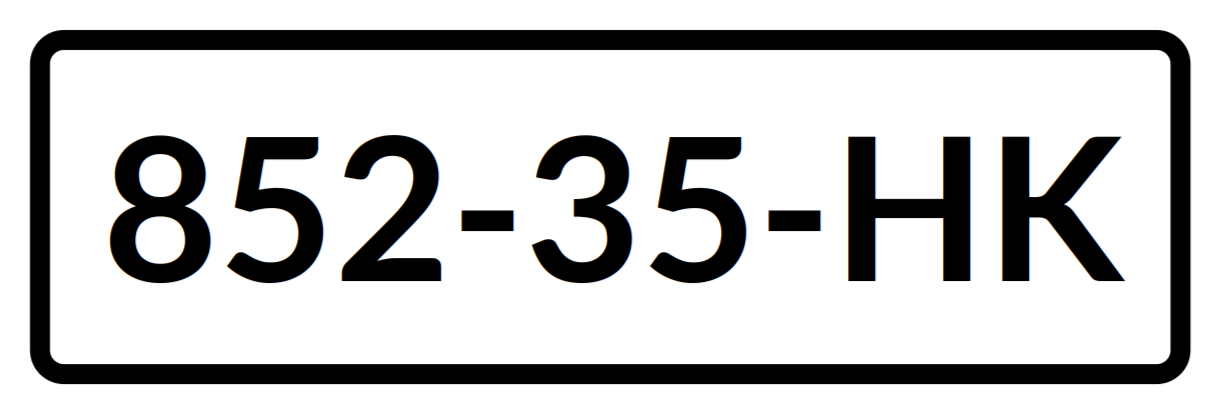

In [3942]:
display_width = 200
params = generate_plate_params()
generate_plate(params, False, f"baseline-plate.png")
generate_plate(params, True, f"highlighted-plate.png")
display(IImage('baseline-plate.png', width=display_width, height=display_width))
display(IImage('highlighted-plate.png', width=display_width, height=display_width))

In [3882]:
def gen_and_save_plate(i, _):
    random.seed(i + int(time()))
    params = generate_plate_params()
    generate_plate(params, False, f"../data/flat-plates/baseline/{i}.png")
    generate_plate(params, True, f"../data/flat-plates/highlight/{i}.png")

parallel(gen_and_save_plate, range(10000))

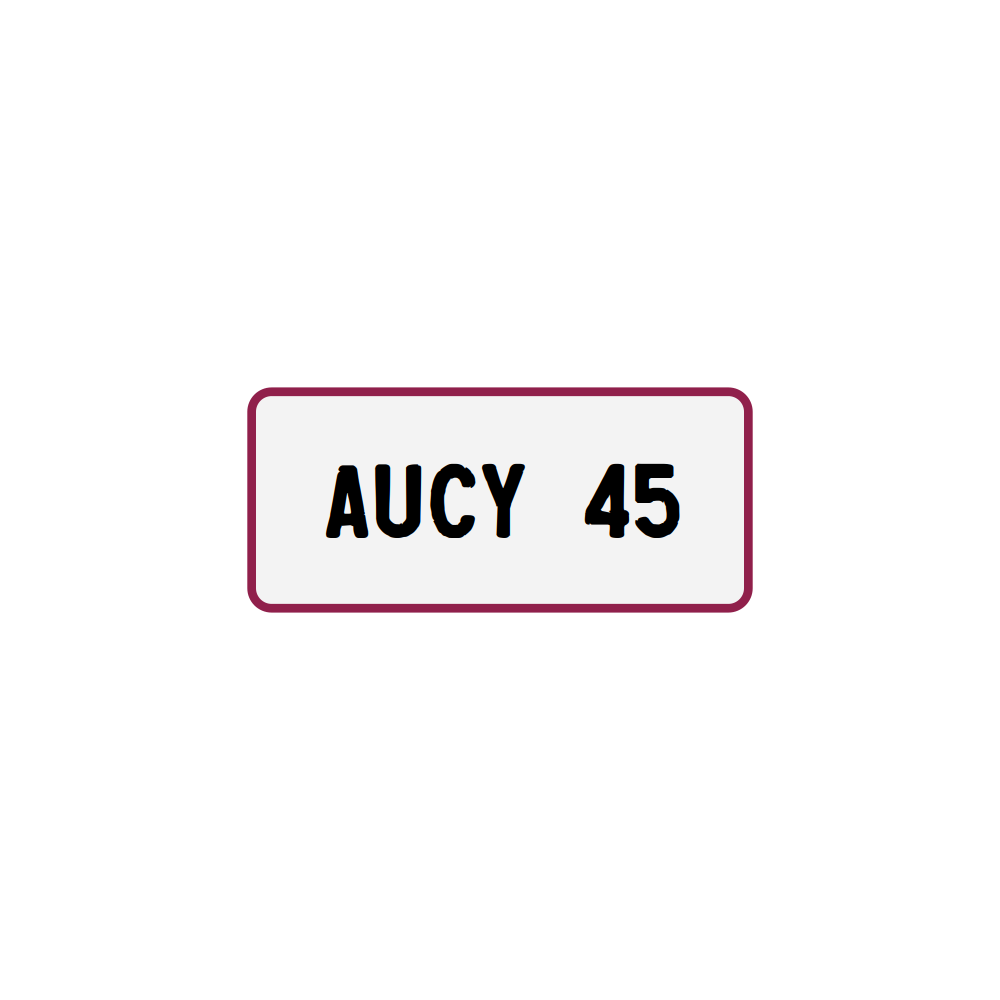

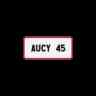

In [1970]:
# Degrade test license plate image
max_width=200
degrade_image('cairo-example.png')
display(IImage('cairo-example.png', width=max_width, height=max_width))
display(IImage('test-degrade.jpg', width=max_width, height=max_width))

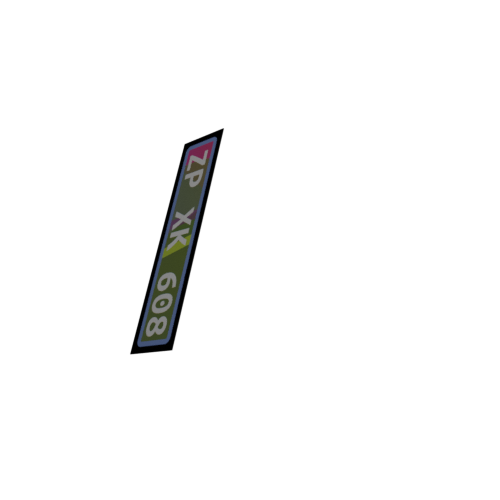

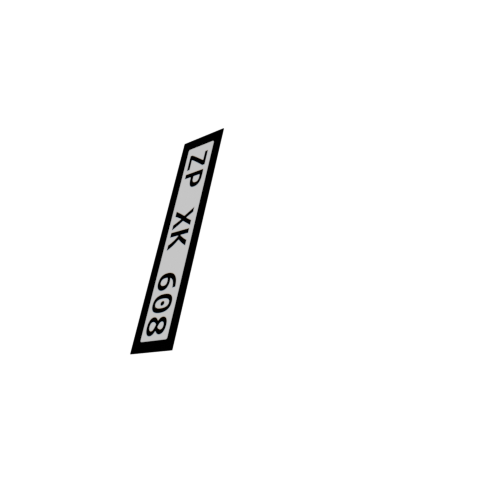

In [3947]:
idx = 90
display(IImage(f'../data/augmented-plates/baseline/{idx}.png', width=max_width, height=max_width))
display(IImage(f'../data/augmented-plates/highlight/{idx}.png', width=max_width, height=max_width))

The approach I went with for getting the license plates in a scene was a Blender script: [../3d_plate_gen](../3d_plate_gen). **Note that [turning on CUDA rendering](https://docs.blender.org/manual/en/latest/render/cycles/gpu_rendering.html) when using Blender's Cycles engine will make rendering go much, much faster.**

Is it possible to turn off lighting in Blender entirely for the highlight render? Seems like that would make things faster too.

We need some sort of a background for our images. I've opted to use Stanford's car dataset: https://ai.stanford.edu/~jkrause/cars/car_dataset.html.

In [3957]:
os.listdir('../data/car_ims/')[:10]

['000817.jpg',
 '001075.jpg',
 '013976.jpg',
 '009982.jpg',
 '001445.jpg',
 '010424.jpg',
 '009977.jpg',
 '001104.jpg',
 '013636.jpg',
 '012359.jpg']

In [4372]:
car_imgs = os.listdir('../data/car_ims/')

def composite_plate_background(i, _):
    plate_foreground_baseline = Image.open(f'../data/augmented-plates/baseline/{i}.png')
    plate_foreground_highlight = Image.open(f'../data/augmented-plates/highlight/{i}.png')
    plate_background_baseline = Image.open(f'../data/car_ims/{random.choice(car_imgs)}').convert("RGBA")
    plate_background_highlight = plate_background_baseline.copy()
    foreground_width = plate_foreground_baseline.size[0]
    w, h = plate_background_baseline.size
    ratio = max(foreground_width / w, foreground_width / h)
    target_size = int(w*ratio), int(h*ratio)
    crop_tuple = (
        (target_size[0] - foreground_width) / 2,
        (target_size[1] - foreground_width) / 2,
        foreground_width + ((target_size[0] - foreground_width) / 2),
        foreground_width + (target_size[1] - foreground_width) / 2,
    )
    # print(crop_tuple)
    plate_background_baseline = plate_background_baseline.resize(target_size).crop(crop_tuple)
    plate_background_highlight = plate_background_highlight.resize(target_size).crop(crop_tuple)
    
    plate_background_baseline.alpha_composite(plate_foreground_baseline)
    plate_background_highlight.alpha_composite(plate_foreground_highlight)
    
    plate_background_baseline.resize((200, 200)).convert("RGB").save(f'../data/plates-backgrounds/baseline/{i}.jpg', quality=10 + random.randint(70))
    plate_background_highlight.convert("RGB").save(f'../data/plates-backgrounds/highlight/{i}.jpg')
    

parallel(composite_plate_background, range(10000))



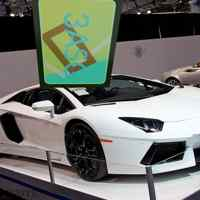

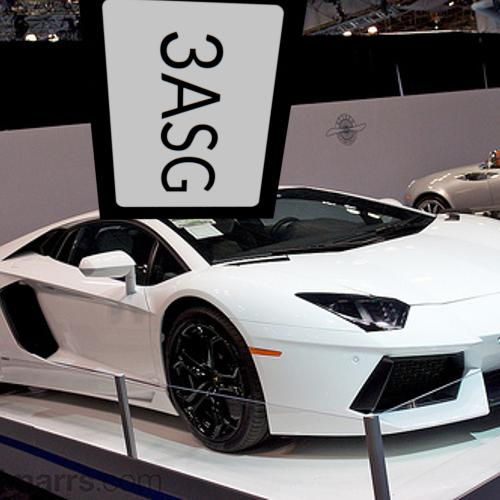

In [4560]:
idx = random.randint(10000)
display(IImage(f'../data/plates-backgrounds/baseline/{idx}.jpg'))
display(IImage(f'../data/plates-backgrounds/highlight/{idx}.jpg'))

The next challenge is building and understanding the U-net. [Here's the paper](https://arxiv.org/pdf/1505.04597.pdf). My approach is going to roughly follow fast.ai while using none of their neural network or training code. I have a weak, high-level view of what the U-net does. I've heard that part of what makes it useful is the skip connections between layers in the encoder and decoder as seen in this figure: ![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Several questions I hope to address:
- How is it possible to upscale a convolution, and how does that lead to the sharp data we want? I've heard it has something to do with the skip concatenation, but I feel like I could understand this more intuitively.
- Why is it that in ResBlocks and DenseBlocks, adding or concatenating are very similar? What does it actually mean to concatenate in this context? I do notice that the layers where some concatenation is happening have twice as many channels.
- Why does the U-net architecture lend itself to generative upscaling? I've seen links to papers specifically about upscaling, but the U-net is the core building block used in fast.ai's examples.
- Are the blue layers in the U-Net diagram fully-connected layers? Is it just a notational choice to represent the convolutions as arrows?
    - According to the paper, blue boxes are "feature maps," which seem like another name for something we covered a lot in the fast.ai course.
        - Yep. [A feature map is just the result of a convolution](https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2). I guess what isn't clear to me right now is where the trainable knobs are. I'll bet PyTorch's [convolution implementation](https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d) would make this clearer.
        - It does. [Check out the source for \_ConvNd](https://github.com/pytorch/pytorch/blob/75155df8b4a1e87e22b6778a51619d9faf7c64f5/torch/nn/modules/conv.py#L17). All the arrows that we're looking at in this diagram are the trainable knobs. I might have been thrown off by the prominence of the blue and white boxes. My thinking was that they were storing something, like a linear layer, but it looks like in this graph they're just a graphical representation of the output from convolutions.
- Why do we have a 1x1 convolution at the end? Wouldn't that mean that each input pixel in each channel is just multiplied by the same scalar value and the dimension isn't changed?
    - Maybe [this](https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/) will clear things up?
    > Deep convolutional neural networks require a corresponding pooling type of layer that can downsample or reduce the depth or number of feature maps.
    >
    > ...
    >
    > The solution is to use a 1×1 filter to down sample the depth or number of feature maps.
    >
    > ...
    >
    > The 1×1 filter is so simple that it does not involve any neighboring pixels in the input; it may not be considered a convolutional operation. Instead, it is a linear weighting or projection of the input. Further, a nonlinearity is used as with other convolutional layers, allowing the projection to perform non-trivial computation on the input feature maps.
    
    Seems to me like what this is saying is that a 1x1 filter lets you take a bunch of feature maps and condense them into a few. ["Downsample" has a great definition here](http://www.cs.cmu.edu/~16831-f14/notes/F11/16831_lecture23_ss1.pdf). **The reason we're doing the 1x1 conv at the end is to downsample to however many channels we need**. This makes sense in the context of image segmentation, where we have $n$ segmentation classes.
- Why is is that we can use the pre-trained weights for ResNet34 as the "architecture" for U-Net learner in fast.ai? I would have thought that U-Net would only be able to use a set of weights for its own architecture. A trip into the fast.ai source could solve this.
- We'll get to that later, I'm sure. How is this normally used for image segmentation? Maybe there are only two classes in the reference paper? That would make sense. That tracks what I'm seeing in [this article from deeplearning.net](http://deeplearning.net/tutorial/unet.html). It also makes intuitive sense. The last layer is made up of $n$ channels, each representing a class. Also, from the paper:
> At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

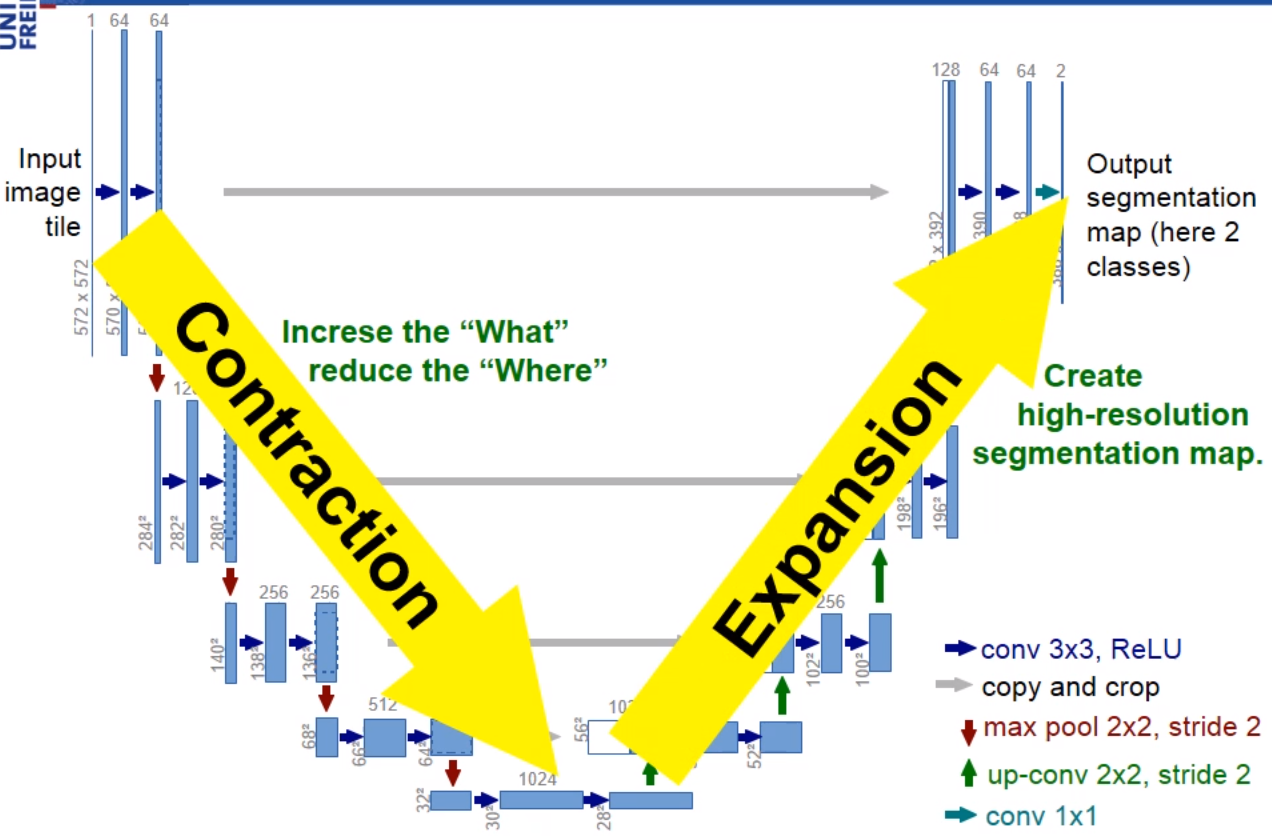

> Increase the "what," reduce the "where"

I'm trying to wrap my mind around this intuitively. The "bottleneck" has 1024 30x30 channels. This data is richer but less spatial. Why would this be useful? What kind of information gets stored here?

Here's what I'm guessing. In a way, we're still solving a segmentation problem when trying to generate upscaled images. The bottleneck's responsibility is identifying things and the jump connections are good at creating the structure? I only have a vague, unarticulated guess of what we're looking at.

I think I'm comfortable moving forward with what I understand about CNNs now. The question is what kind of U-Net I want to build. Fast.ai's `DynamicUnet` has a lot of implementation details beyond what is covered in the U-Net paper. So:
- Do I want to determine if the network in the paper works well for this generation application
    - How hard is it to set up the discriminator as input in the loss function?
- Do I want to try to just understand fast.ai's implementation, play by play?

Why don't we start simple and adjust if results aren't where we want them? Sounds like a good idea.

Here's the approach:
- Attempt to create a U-net using just the paper and what documentation I can find for PyTorch without looking at any U-net implementations
- Once I've either built something that I think would work or I get truly stuck, find multiple implementations and try to understand what they have in common. Tweak my own approach.

One thing I need to figure out is how these jump connections should work in theory. Maybe PyTorch already has something? We'll need to use hooks for sure, but maybe what I'm not sure about is how we'd actually concatenate things during training. I don't think I have good model of how backpropogation works in PyTorch, not really. The tutorial [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for training an image classifier could be useful, at least for getting started. Maybe all we need is that and some more information about how hooks work.